In [1]:
# ==========================================
# 1. Setup do Ambiente
# ==========================================
from google.colab import drive
import sys
import os

# Montar Drive (opcional, se estiver salvando lá)
drive.mount('/content/drive')

# Clonar repositório (se não estiver rodando local)
!git clone https://github.com/vggd18/telecom-churn-project.git
%cd telecom-churn-project
!git checkout feature/mlp_treaning

# Instalar dependências específicas
!pip install -q xgboost pykan

# Adicionar diretório atual ao path para importações funcionarem
sys.path.append('.')

Mounted at /content/drive
Cloning into 'telecom-churn-project'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 91 (delta 41), reused 69 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (91/91), 29.72 KiB | 4.25 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/telecom-churn-project
Branch 'feature/mlp_treaning' set up to track remote branch 'feature/mlp_treaning' from 'origin'.
Switched to a new branch 'feature/mlp_treaning'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.1/78.1 kB 2.8 MB/s eta 0:00:00


In [2]:
# ---------------------------------------------------------
# CORREÇÃO PARA AUTORELOAD NO PYTHON 3.12 (Google Colab)
# Executar na primeira célula do notebook
# ---------------------------------------------------------
import sys
import importlib

# O Python 3.12 removeu o 'imp', mas o autoreload antigo precisa dele.
# Vamos criar um "falso" imp apontando para o importlib.
if 'imp' not in sys.modules:
    sys.modules['imp'] = importlib

# Agora sim, carregamos a extensão mágica
%load_ext autoreload
%autoreload 2

In [5]:
# # 1. Baixa as informações mais recentes do GitHub (sem tentar mesclar ainda)
!git fetch origin

# # 2. Reseta o estado atual do Colab para ficar IDÊNTICO ao do GitHub
!git reset --hard origin/feature/mlp_treaning

remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 4 (delta 1), reused 4 (delta 1), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 1.14 KiB | 1.14 MiB/s, done.
From https://github.com/vggd18/telecom-churn-project
   996c9e3..0d27ff8  feature/mlp_treaning -> origin/feature/mlp_treaning
HEAD is now at 0d27ff8 feat(models): implement MLPModel with training, prediction, and model persistence


In [3]:
# ==========================================
# Célula para Baixar Dados (Kaggle)
# ==========================================
import kagglehub
import shutil
import os

print("⬇️ Baixando dataset do Kaggle...")
# Baixa a versão mais recente
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")

print(f"📂 Dataset baixado em: {path}")

# Caminhos de destino
dest_dir = "data/raw"
dest_file = "telecom_churn.csv"
dest_path = os.path.join(dest_dir, dest_file)

# Criar pasta se não existir
os.makedirs(dest_dir, exist_ok=True)

# O arquivo original geralmente vem com este nome:
source_file = os.path.join(path, "customer_churn_telecom_services.csv")

# Mover e renomear
if os.path.exists(source_file):
    shutil.copy(source_file, dest_path)
    print(f"✅ Arquivo movido com sucesso para: {dest_path}")
else:
    print(f"⚠️ Arquivo não encontrado em {source_file}. Verifique o conteúdo da pasta baixada.")
    print(os.listdir(path))

⬇️ Baixando dataset do Kaggle...
Using Colab cache for faster access to the 'customers-churned-in-telecom-services' dataset.
📂 Dataset baixado em: /kaggle/input/customers-churned-in-telecom-services
✅ Arquivo movido com sucesso para: data/raw/telecom_churn.csv


In [4]:
# ==========================================
# 2. Executar Pipeline de Dados
# ==========================================
# Isso garante que os arquivos .npy existam e sigam a lógica do Slide 33
!python scripts/prepare_data.py

🚀 PIPELINE DE PREPROCESSAMENTO (seguindo PDF)

📂 1. Carregando dados...
   Shape original: (7043, 20)
   Missing values: 11
   ⚠️  Removendo linhas com missing
   Shape após limpeza: (7032, 20)
   ✓ Churn convertido para 0/1
   Distribuição Churn: {0: 5163, 1: 1869}

✂️ 2. Particionamento (50/25/25)...
   Classe 0 (No Churn): 5163
   Classe 1 (Churn): 1869

   Split Classe 0:
      Train: 2581
      Val: 1290
      Test: 1292

   Split Classe 1:
      Train: 934
      Val: 467
      Test: 468
   ✅ Verificação: Sem overlap entre splits

   Conjuntos (ANTES do balanceamento):
      Train: (3515, 20) - Dist: {0: 2581, 1: 934}
      Val: (1757, 20) - Dist: {0: 1290, 1: 467}
      Test: (1760, 20) - Dist: {0: 1292, 1: 468}

📏 4. Pré-processamento (encoding + normalização)...
   Numéricas: 4 colunas
   Categóricas: 15 colunas
   Aplicando transformações...
   ✓ Train processado: (3515, 30)
   ✓ Val processado: (1757, 30)
   ✓ Test processado: (1760, 30)

   Validação da normalização:
      T

In [9]:
# ==========================================
# 3. Imports e Carregamento dos Dados
# ==========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

# Importando SUAS classes e funções
from models.mlp_model import MLPModel
from src.metrics import calculate_all_metrics
from src.visualization import plot_ks_statistic, plot_roc_curve, plot_confusion_matrix

# Carregar dados processados (gerados pelo prepare_data.py)
DATA_DIR = 'data/processed'

X_train = np.load(f'{DATA_DIR}/X_train.npy')
y_train = np.load(f'{DATA_DIR}/y_train.npy')
X_val = np.load(f'{DATA_DIR}/X_val.npy')
y_val = np.load(f'{DATA_DIR}/y_val.npy')
X_test = np.load(f'{DATA_DIR}/X_test.npy')
y_test = np.load(f'{DATA_DIR}/y_test.npy')

print(f"✅ Dados carregados!")
print(f"Train: {X_train.shape} (Balanceado)")
print(f"Val:   {X_val.shape} (Balanceado)")
print(f"Test:  {X_test.shape} (Desbalanceado/Real)")

# Helper simples para exibir métricas no notebook
def print_metrics(dataset_name, metrics):
    print(f"--- {dataset_name} ---")
    print(f"KS:        {metrics['ks']:.4f} (Threshold: {metrics['ks_threshold']:.2f})")
    print(f"AUROC:     {metrics['auroc']:.4f}")
    print(f"F1 Score:  {metrics['f1']:.4f}")

✅ Dados carregados!
Train: (5162, 30) (Balanceado)
Val:   (2580, 30) (Balanceado)
Test:  (1760, 30) (Desbalanceado/Real)


🚀 Treinando MLP...
--- MLP (Teste) ---
KS:        0.4986 (Threshold: 0.39)
AUROC:     0.8277
F1 Score:  0.5985


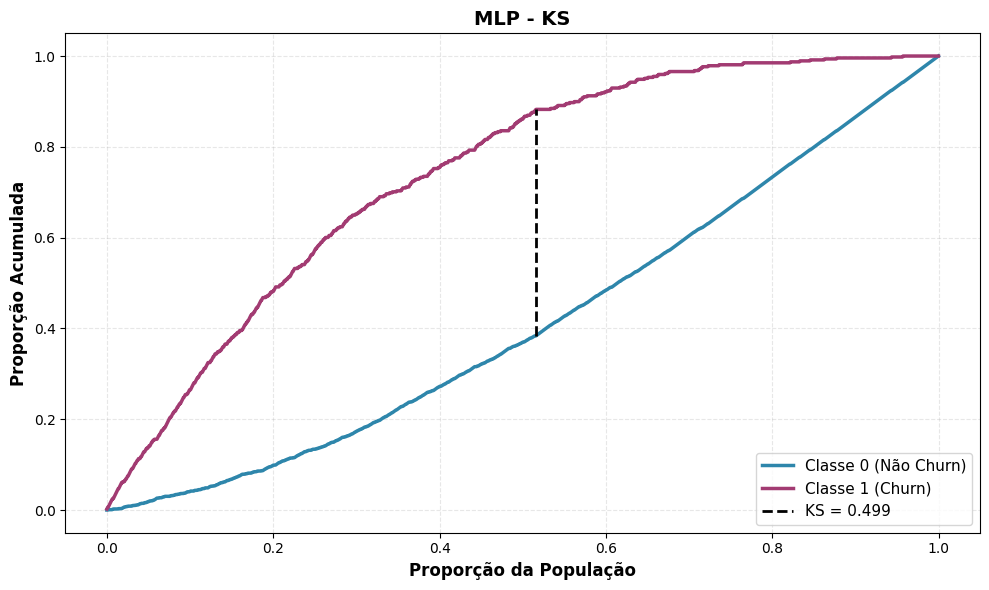

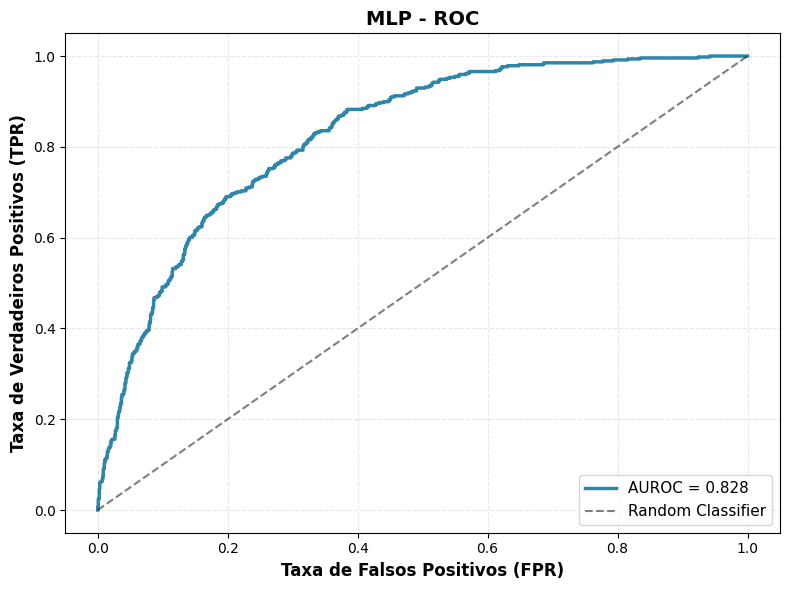

In [10]:
# ============================
# 4. Experimento: MLP (Sklearn)
# ============================
print("🚀 Treinando MLP...")

mlp = MLPModel(name="MLP_Baseline")
mlp.build(hidden_layer_sizes=(10,), activation="relu", learning_rate_init=0.001, max_iter=10000)
mlp.train(X_train, y_train, X_val, y_val)

# Avaliação no Teste
y_pred_mlp = mlp.predict_proba(X_test)[:, 1]
metrics_mlp = calculate_all_metrics(y_test, y_pred_mlp)

print_metrics("MLP (Teste)", metrics_mlp)

# Visualizações
plot_ks_statistic(y_test, y_pred_mlp, title="MLP - KS")
plot_roc_curve(y_test, y_pred_mlp, title="MLP - ROC")
